# Notebook 03 — PPO vs Baselines (Matched Episodes)

Goal: test whether PPO learned anything meaningful by comparing it against simple baseline strategies on the **same symbols** and **the same episode start windows**.

Why “matched episodes” matters:
- If PPO and baselines start on different dates or different tickers, the comparison is unfair.
- Here we control randomness (seed) and force the same symbol so each policy sees the same market path.

Baselines:
- **flat**: always 0% exposure
- **buy_hold**: always 100% exposure
- **avoid_earnings**: 0% exposure during earnings window, otherwise 100%

## Setup: Imports & project paths

Purpose:
- Make the notebook reproducible no matter where it’s launched from.
- Ensure `earningsedge_rl` imports work by adding `src/` to `sys.path`.

In [1]:
from __future__ import annotations

from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- robust project root detection ---
ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

SRC = ROOT / "src"
os.chdir(ROOT)

import sys
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("ROOT:", ROOT)
print("SRC:", SRC)

ROOT: /home/btheard/projects/earningsedge-rl
SRC: /home/btheard/projects/earningsedge-rl/src


In [2]:
from stable_baselines3 import PPO
from earningsedge_rl.env.trading_env import TradingEnv, ACTION_LEVELS

print("ACTION_LEVELS:", ACTION_LEVELS)

ACTION_LEVELS: [0.   0.25 0.5  1.  ]


## Load Sprint run artifacts (model + universe split)

Purpose:
- Point this notebook at the **trained PPO model** from Sprint 4.
- Load the **train/test ticker split** so evaluation uses **test symbols only** (true generalization).
- Fail fast if paths are wrong (print existence checks).

In [ ]:
RUN_DIR = ROOT / "runs" / "sprint4_generalization"   # recommended
# RUN_DIR = ROOT / "runs" / "sprint3_ppo"            # fallback

MODEL_PATH = RUN_DIR / "ppo_trading_env.zip"
SPLIT_PATH = RUN_DIR / "universe_split.json"         # exists in sprint4

print("RUN_DIR:", RUN_DIR)
print("MODEL_PATH exists:", MODEL_PATH.exists())
print("SPLIT_PATH exists:", SPLIT_PATH.exists())

split = None
if SPLIT_PATH.exists():
    split = json.loads(SPLIT_PATH.read_text())
    print("train symbols:", len(split["train"]))
    print("test symbols:", len(split["test"]))

RUN_DIR: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization
MODEL_PATH exists: True
SPLIT_PATH exists: True
train symbols: 160
test symbols: 40


## Load PPO policy

Purpose:
- Load the trained SB3 PPO model from disk.
- We evaluate with `deterministic=True` so results are stable and repeatable.

In [4]:
model = PPO.load(str(MODEL_PATH), device="cpu")
print("Loaded PPO from:", MODEL_PATH)

Loaded PPO from: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/ppo_trading_env.zip


## Define the policies we will compare

We evaluate four policies:
- **ppo**: the trained agent chooses exposure actions
- **buy_hold**: always full exposure (100%)
- **flat**: always no exposure (0%)
- **avoid_earnings**: go flat during earnings window, otherwise full exposure

Why:
- These baselines give context. PPO only “matters” if it beats something simple on risk-adjusted behavior.

In [5]:
def select_action(policy: str, obs: np.ndarray, model: PPO | None = None) -> int:
    if policy == "ppo":
        assert model is not None
        action, _ = model.predict(obs, deterministic=True)
        return int(action)
    if policy == "buy_hold":
        return 3  # 100%
    if policy == "flat":
        return 0  # 0%
    if policy == "avoid_earnings":
        # obs = [..., dte, dse, eflag, exposure] => eflag is obs[-2]
        eflag = float(obs[-2])
        return 0 if eflag >= 0.5 else 3
    raise ValueError(f"Unknown policy: {policy}")

## Matched episode runner (fair comparison)

Key idea:
- Use the **same symbol** and the **same seed** so each policy starts at the same episode window.
- That means performance differences come from the policy — not from “getting lucky” with a different market period.

What we collect each episode:
- equity curve (portfolio value over time)
- max drawdown
- final equity

In [6]:
def run_episode(
    policy: str,
    seed: int,
    symbol: str,
    episode_len: int = 252,
    model: PPO | None = None,
):
    env = TradingEnv(seed=seed, symbol=symbol, episode_len=episode_len)
    obs, info = env.reset(seed=seed)

    equity_curve = [1.0]
    drawdown_curve = [0.0]

    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = select_action(policy, obs, model=model)
        obs, reward, terminated, truncated, step_info = env.step(action)

        equity_curve.append(float(step_info["equity"]))
        drawdown_curve.append(float(step_info["drawdown"]))

    out = {
        "policy": policy,
        "symbol": info["symbol"],
        "final_equity": float(equity_curve[-1]),
        "max_drawdown": float(np.max(drawdown_curve)),
        "equity_curve": equity_curve,
        "drawdown_curve": drawdown_curve,
    }
    return out

## Aggregate episode results into readable metrics

We summarize each policy with:
- mean / median final equity
- mean max drawdown

Why:
- equity curves vary a lot per ticker + episode window.
- averaging across seeds gives a better estimate of general performance.

In [7]:
def summarize(episodes: list[dict]) -> dict:
    finals = np.array([e["final_equity"] for e in episodes], dtype=float)
    mdds = np.array([e["max_drawdown"] for e in episodes], dtype=float)
    return {
        "mean_final_equity": float(finals.mean()),
        "median_final_equity": float(np.median(finals)),
        "mean_max_drawdown": float(mdds.mean()),
        "n": int(len(episodes)),
    }

## Choose evaluation symbols (test set)

If a Sprint 4 train/test split exists:
- evaluate on **test symbols only** → real generalization

Otherwise:
- fall back to a small sample from the universe for quick iteration.

In [8]:
# choose 5–10 test symbols for notebook speed
if split is not None:
    symbols_eval = split["test"][:10]
    print("Using TEST symbols:", len(symbols_eval))
else:
    universe_path = ROOT / "data" / "processed" / "universe_top200.csv"
    uni = pd.read_csv(universe_path)
    symbols_eval = uni["symbol"].astype(str).tolist()[:10]
    print("Using universe symbols:", len(symbols_eval))

symbols_eval[:10]

Using TEST symbols: 10


['UAL', 'AIG', 'HLT', 'QCOM', 'AAPL', 'PSHG', 'PEP', 'CMCSA', 'ANTM', 'BIDU']

## Run matched evaluation (this is the expensive step)

We loop:
- over each test symbol
- over multiple seeds (each seed picks a different start window)
- over each policy (PPO + baselines)

This creates “multiple episodes per symbol” while keeping comparisons fair.

Note:
- This cell can take a long time because each environment step does feature computation + pandas access.

In [9]:
policies = ["ppo", "buy_hold", "flat", "avoid_earnings"]

n_seeds = 5          # increase later if you want
episode_len = 252    # keep consistent with training

all_eps = []
for sym in symbols_eval:
    for seed in range(n_seeds):
        for p in policies:
            ep = run_episode(
                policy=p,
                seed=seed,
                symbol=sym,
                episode_len=episode_len,
                model=model if p == "ppo" else None,
            )
            all_eps.append(ep)
        print(f"done symbol={sym} seed={seed}")

done symbol=UAL seed=0
done symbol=UAL seed=1
done symbol=UAL seed=2
done symbol=UAL seed=3
done symbol=UAL seed=4
done symbol=AIG seed=0
done symbol=AIG seed=1
done symbol=AIG seed=2
done symbol=AIG seed=3
done symbol=AIG seed=4
done symbol=HLT seed=0
done symbol=HLT seed=1
done symbol=HLT seed=2
done symbol=HLT seed=3
done symbol=HLT seed=4
done symbol=QCOM seed=0
done symbol=QCOM seed=1
done symbol=QCOM seed=2
done symbol=QCOM seed=3
done symbol=QCOM seed=4
done symbol=AAPL seed=0
done symbol=AAPL seed=1
done symbol=AAPL seed=2
done symbol=AAPL seed=3
done symbol=AAPL seed=4
done symbol=PSHG seed=0
done symbol=PSHG seed=1
done symbol=PSHG seed=2
done symbol=PSHG seed=3
done symbol=PSHG seed=4
done symbol=PEP seed=0
done symbol=PEP seed=1
done symbol=PEP seed=2
done symbol=PEP seed=3
done symbol=PEP seed=4
done symbol=CMCSA seed=0
done symbol=CMCSA seed=1
done symbol=CMCSA seed=2
done symbol=CMCSA seed=3
done symbol=CMCSA seed=4
done symbol=ANTM seed=0
done symbol=ANTM seed=1
done sy

## Metrics table

We convert the collected episode records into a table so we can:
- compare mean/median equity by policy
- compare drawdown behavior
- quickly spot if PPO is adding value vs baselines

In [10]:
df = pd.DataFrame(all_eps)

summary = (
    df.groupby("policy")
      .apply(lambda g: pd.Series(summarize(g.to_dict("records"))))
      .reset_index()
      .sort_values("mean_final_equity", ascending=False)
)

summary

/tmp/ipykernel_24859/2874386274.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(summarize(g.to_dict("records"))))


,policy,mean_final_equity,median_final_equity,mean_max_drawdown,n
1,buy_hold,1.085520,1.123019,0.276996,50.0
0,avoid_earnings,1.046523,1.049213,0.254948,50.0
3,ppo,1.039345,1.067344,0.247361,50.0
2,flat,1.000000,1.000000,0.000000,50.0


## Equity curve visualization (one matched episode)

We plot one symbol + one seed across all policies.

Why:
- The metrics summarize “how it did overall”
- The plot shows “how it behaved” (risk, drawdowns, timing, earnings windows)

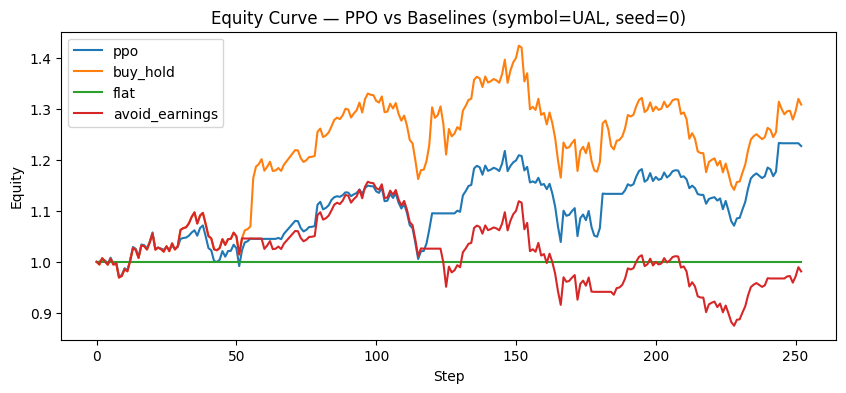

In [11]:
example_sym = symbols_eval[0]
example_seed = 0

eps = []
for p in policies:
    eps.append(run_episode(
        policy=p,
        seed=example_seed,
        symbol=example_sym,
        episode_len=episode_len,
        model=model if p == "ppo" else None
    ))

plt.figure(figsize=(10, 4))
for ep in eps:
    plt.plot(ep["equity_curve"], label=ep["policy"])
plt.title(f"Equity Curve — PPO vs Baselines (symbol={example_sym}, seed={example_seed})")
plt.xlabel("Step")
plt.ylabel("Equity")
plt.legend()
plt.show()

## Save artifacts (reproducible outputs)

We optionally save:
- per-episode curves (JSON)
- summary metrics (JSON)

Why:
- lets you regenerate plots later without re-running the 10+ hour evaluation
- makes results easy to use in Notebook 04 (visualizations) and the React dashboard later

In [12]:
OUT_DIR = RUN_DIR / "notebook03_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

(df.to_dict("records"))
(OUT_DIR / "episodes.json").write_text(json.dumps(df.to_dict("records"), indent=2))
(OUT_DIR / "summary.json").write_text(summary.to_json(orient="records", indent=2))

print("Saved:", OUT_DIR)

Saved: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook03_outputs


## How to interpret results (what “good” looks like)

- If PPO beats **flat**, it learned to take risk.
- If PPO beats **buy_hold**, it learned risk management / timing (harder).
- If PPO beats **avoid_earnings**, it learned something beyond the simplest earnings-aware rule.
- If PPO underperforms, that’s still useful: it tells us what to improve (features, reward, training horizon, action space, etc.).